# Prerequisites

For using `jwave`, you need to be familiar with `jax` and the package `jaxdf`. This page provides a quick introduction to allow you to get started with running simulations.

## JAX

[jax](https://github.com/google/jax) is a Python library for machine learning and scientific computing, on which `jwave` is based. To learn how to use `jax`, please refer to [this guide](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html). For our purposes, the two main features of `jax` that one needs to keep in mind for using `jwave`:

#### 1. `jax` is a drop-in replacement for `numpy`

Writing functions that operate on arrays in `jax` is extremely similar to doing it in NumPy. For example, we can write a function that calculates a polynomial function of the input and apply it to an array

In [ ]:
from jax import numpy as jnp

def f(x, y, a=1.,b=1.):
    return a*(x**2) + b*y

# Testing function
x = 2.
y = 3.

z = f(x, y, 3.,2.)

print(f"(x,y) = {[x,y]}\tf(x,y) = {z}")

(x,y) = [2.0, 3.0]	f(x,y) = 18.0


However, some operations, like in-place updates of arrays, are not permitted. For more details on this, see the [Sharp Bits](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html) section of the `jax` documentation.

#### 2. `jax` power comes from function transformations.

One of the main features of `jax` is function transformations. It is a concept that may be unfamiliar, especially for users coming from MATLAB (a related concept is [function handles](https://uk.mathworks.com/help/matlab/matlab_prog/call-local-functions-using-function-handles.html)). 

The fundamental idea is to have special functions (from now on called *function transformations* or [high-order functions](https://en.wikipedia.org/wiki/Higher-order_function)) that take a function as input and return a function ad output. They are also related to the concept of [python decorator](https://peps.python.org/pep-0318/). 

To make things concrete, an example of function transformation (say $\mathcal{T}$) is one that transform a generic $f(x,y)$ by swapping the $x$ and $y$, yelding the new function $T(f)(x,y) = g(x,y) = f(y,x)$.

In [ ]:
def swap_coordinates(f):
    def g(x, y, *args, **kwargs): 
        return f(y, x, *args, **kwargs)
    return g
    
# Gets the new function
f_swapped = swap_coordinates(f)

# Evaluates the new function
w = f_swapped(x, y, 3., 2.)

print(f"(x,y) = {[x,y]}\t         f(x,y) = {z}")
print(f"(x,y) = {[x,y]}\tg(x,y) = f(y,x) = {w}")

(x,y) = [2.0, 3.0]	         f(x,y) = 18.0
(x,y) = [2.0, 3.0]	g(x,y) = f(y,x) = 31.0


`jax` comes equipped with many transformations that are useful for machine learning research. One of those transformations is `jax.grad`, which [applies the gradient operator](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html) to a function with a scalar output.

In [ ]:
import jax

# Gets the gradient function
grad_f = jax.grad(f, argnums=(0,1))

# Evaluates the new function
x = 2.
y = 4.
z = f(x, y, 3., 2.)
x_prime, y_prime = grad_f(x, y, 3., 2.)

print(f"(x,y) = {[x,y]}\tf(x,y) = {z}   \tf'(x,y) = {[str(x_prime), str(y_prime)]}")

(x,y) = [2.0, 4.0]	f(x,y) = 20.0   	f'(x,y) = ['12.0', '2.0']


Another important function transformation is [`jax.jit`](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html#using-jit-to-speed-up-functions), which returns a version of the function optimized and compiled for the user hardware

In [ ]:
def complex_fun(x):
    y = jnp.sqrt((x+1)**2)
    z = jnp.sin(x*3 + x**2 + 1)
    return jnp.sum(z*y + y)

# Gets the compiled function
f_jit = jax.jit(complex_fun)

# Evaluates the new function
x = jnp.ones((10000,10000));
z = complex_fun(x)
z_jit = f_jit(x) # The function is compiled at its first call

In [ ]:
%timeit complex_fun(x)

793 ms ± 818 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit f_jit(x).block_until_ready()

242 ms ± 887 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Fields

**Objects** are variables that contain the numerical data used during the simulations. They are often defined as classes registered to the JAX compiler as a custom PyTree node, meaning that they can be passed to functions in the same way as `jax.numpy` arrays, and they can be initialized within a function. 

One example is the `Domain` class from `jwave.geometry`, which defines the domain where the simulation takes place.

In [ ]:
from jwave.geometry import Domain

domain = Domain(N=(65,65), dx=(1., 1.))
print(domain)

Domain(N=(65, 65), dx=(1.0, 1.0))


Other objects are defined as `Field` subclasses from [`jaxdf`](https://github.com/ucl-bug/jaxdf). A `Field`, in a nutshell, consists of parameters and a representation (or discretization), associated with a domain. For example, the following defines a truncated Fourier Series, for which the value in $(0,0)$ is 1.

In [ ]:
from jwave.geometry import FourierSeries

params = jnp.zeros(domain.N)
params = params.at[32,32].set(1.0)
u = FourierSeries(params, domain)

We can visualize this field on the grid

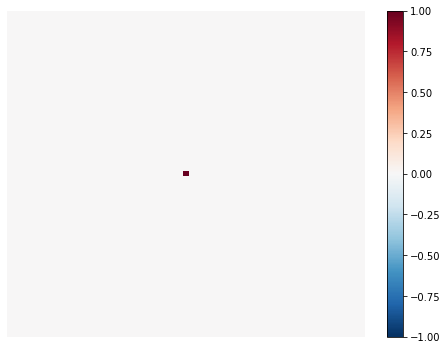

In [ ]:
from jwave.utils import show_field

show_field(u)

Or query the field at a specific point in space

In [ ]:
x = jnp.asarray([0., 0.])
print(u(x))

[1.]


We can also use the latter callable to visualize the underlying discretization, i.e. the bandlimited interpolant, by querying the field at values outside the grid nodes. Here we are usign the [vmap](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html#jax.vmap) function transformation, to efficiently query the field at multiple points. 

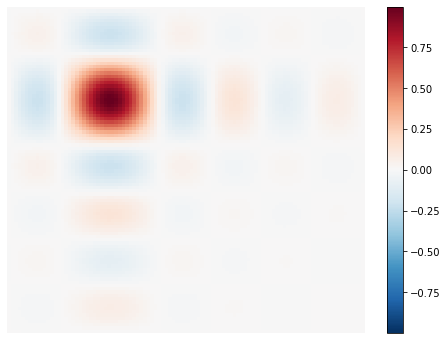

In [ ]:
field_on_plane = jax.vmap(jax.vmap(u))

x = jnp.linspace(-2, 5, 100)
X, Y = jnp.meshgrid(x,x)
coords = jnp.stack([X,Y], -1)
z = field_on_plane(coords).real[...,0]

show_field(z)

Lastly, there are *operators* that can be applied to `Field` objects. Operators are objects that represent some mathematical operator on functions, such as the gradient or the Helmholtz equation, whose numerical implementation depends on the input discretization. They return functions and they can be used inside a function to be transformed using `jax`.

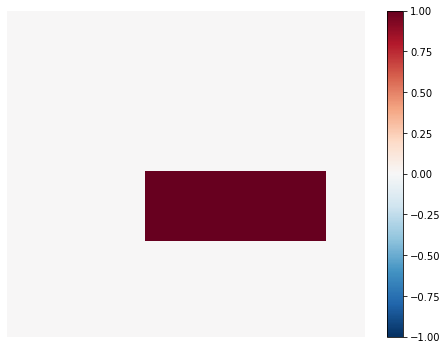

In [ ]:
from jaxdf.operators import laplacian

params = jnp.zeros(domain.N)
params = params.at[32:46,25:58].set(1.0)
u = FourierSeries(params, domain)

show_field(u)

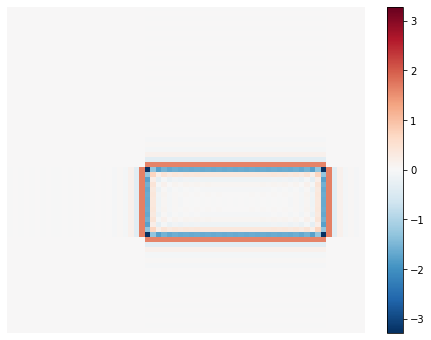

In [ ]:
v = laplacian(u)
show_field(v)

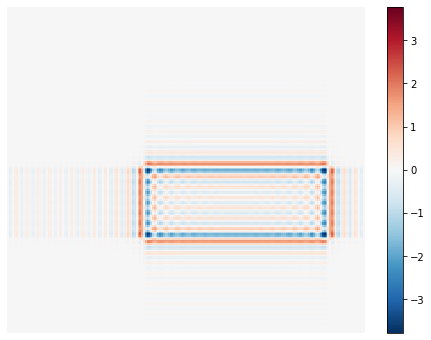

In [15]:
# It is still a Field, so it can be visualized it at higher resolutions 
# using the same method as before
field_on_plane = jax.vmap(jax.vmap(v))

x = jnp.linspace(-32, 32, 200)
X, Y = jnp.meshgrid(x,x)
coords = jnp.stack([X,Y], -1)
z = field_on_plane(coords).real[...,0]
z = jnp.fliplr(jnp.fliplr(z).T)

show_field(z)

## Running a simulation

Knowing how to use `jax` and the `jaxdf` objects from `jaxdf`, you can run your first simulation by following the next tutorial.